## Calculate the average winter temperature at snotel sites

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [1]:
# %%
# snotel = input('Enter the desired SNOTEL site code (ie. 1107:WA): ') + ':SNTL'


# print('********** generating the forcing file, please be patient **********')
# print('********** should take ~3 minutes to run **********')
# %% [markdown]
# ## Use metloom API to pull snotel data

# %%
import warnings
# pysumma has many depreciated packages, this ignores their warnings
warnings.filterwarnings("ignore", category=UserWarning, module='scipy')

from datetime import datetime, timedelta
from metloom.pointdata import SnotelPointData
import pandas as pd
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from metpy.units import units
import metpy.calc as mpcalc
import math
import scipy
import os
import shutil
from pytz import UTC
import pysumma as ps
import pysumma.plotting as psp


import sys
sys.path.append('/home/cdalden/summa_setup/model')
from utils import lw_clr
from utils import forcing_filler as ff
from utils import summa_check as sc


# metsim and metloom require different formats of time and ranges, reformat here





In [11]:
sntls = pd.read_csv('/home/cdalden/summa_setup/analysis/sntl_list_temps.csv')

0      908
1      352
2      375
3      376
4      942
5      418
6      420
7     1319
8      943
9      910
10     478
11     502
12     507
13     515
14     928
15     553
16     591
17     599
18     606
19     897
20     642
21     644
22     648
23     898
24     941
25     672
26     679
27     681
28     692
29     699
30     702
31     707
32     711
33     911
34     728
35     734
36     748
37     912
38     776
39     777
40     788
41     791
42     804
43     975
44     817
45     899
46     824
47     832
48     841
49     974
50     909
51     863
Name: site_code, dtype: int64

In [12]:
start_date = datetime(2000, 10, 1)
end_date = datetime(2024, 9, 30)

In [15]:
for i in sntls.site_code:
    # %%
    # Pull desired variables from snotel to dataframe
    # snotel_point = SnotelPointData(snotel, "MyStation")
    snotel_point = SnotelPointData(f'{str(i)}:WA:SNTL', "MyStation")
    df = snotel_point.get_hourly_data(
        start_date, end_date,
        [snotel_point.ALLOWED_VARIABLES.TEMP]
    )

    # Specify latitude, longitude, and elevation from station metadata
    lat = snotel_point.metadata.y
    lon = snotel_point.metadata.x
    elev = snotel_point.metadata.z

    # Clean up the dataframe
    df.reset_index(inplace=True)

    # Rename columns
    replace = {'AIR TEMP':'airtemp', 'datetime':'time'}
    df.rename(columns=replace, inplace=True)
    df.set_index('time', inplace=True)

    # Select data for December, January, and February
    winter_months = df[(df.index.month == 12) | (df.index.month == 1) | (df.index.month == 2)] 
    mean_temp_djf = winter_months['airtemp'].mean()

    # Save the mean temperature for the winter months
    sntls.loc[sntls.site_code == i, 'mean_temp_djf'] = mean_temp_djf
    print(f'{i} mean winter temp: {mean_temp_djf}')

sntls.to_csv('/home/cdalden/summa_setup/analysis/sntl_list_temps.csv', index=False)

KeyboardInterrupt: 

In [8]:
# Select data for December, January, and February
winter_months = df[(df.index.month == 12) | (df.index.month == 1) | (df.index.month == 2)]

In [9]:
winter_months.airtemp.mean()

21.135669891998234

In [17]:
snotel_point = SnotelPointData(f'679:WA:SNTL', "MyStation")
df = snotel_point.get_daily_data(
    start_date, end_date,
    [snotel_point.ALLOWED_VARIABLES.TEMP]
)

# Specify latitude, longitude, and elevation from station metadata
lat = snotel_point.metadata.y
lon = snotel_point.metadata.x
elev = snotel_point.metadata.z

# Clean up the dataframe
df.reset_index(inplace=True)

# Rename columns
replace = {'AIR TEMP':'airtemp', 'datetime':'time'}
df.rename(columns=replace, inplace=True)
df.set_index('time', inplace=True)

# Select data for December, January, and February
winter_months = df[(df.index.month == 12) | (df.index.month == 1) | (df.index.month == 2)] 
mean_temp_djf = winter_months['airtemp'].mean()

# Save the mean temperature for the winter months
sntls.loc[sntls.site_code == i, 'mean_temp_djf'] = mean_temp_djf
print(f'{i} mean winter temp: {mean_temp_djf}')

sntls.to_csv('/home/cdalden/summa_setup/analysis/sntl_list_temps.csv', index=False)

908 mean winter temp: 26.877576318223866


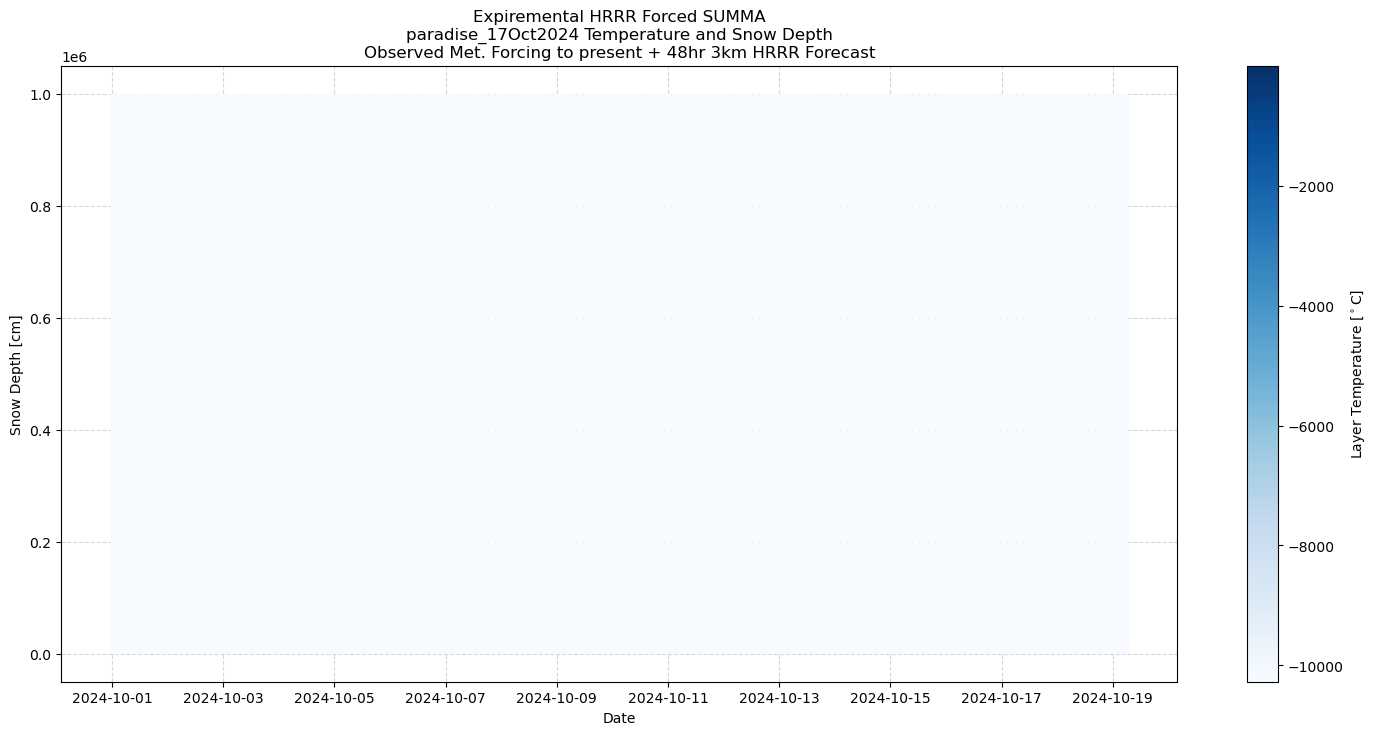

In [15]:
# Create and save density and temp profile plots
out = xr.open_dataset('/home/cdalden/summa_setup/model/output/output_paradise_17Oct2024_timestep.nc')
out_name = 'paradise_17Oct2024'

# out['mLayerDepth'] = out['mLayerDepth']*100
# out['mLayerHeight'] = out['mLayerHeight']*100
# out['iLayerHeight'] = out['iLayerHeight']*100
# out['scalarSnowDepth'] = out['scalarSnowDepth']*100


# define variables to be plotted from output
depth = out.isel(hru=0)['iLayerHeight']
temp = out.isel(hru=0)['mLayerTemp']-273.15
# frac_wat = out.isel(hru=0)['mLayerVolFracWat']*1000

# plot snow depth and layer temperature
plot = psp.layers(temp, depth*100, colormap='Blues', plot_soil=False, plot_snow=True, add_colorbar=True, cbar_kwargs={'label': 'Layer Temperature [$^\circ$C]'})
# out['scalarSnowDepth'].plot(color='red', linewidth=2)
plt.title('Expiremental HRRR Forced SUMMA\n'+out_name+' Temperature and Snow Depth\nObserved Met. Forcing to present + 48hr 3km HRRR Forecast')
plt.xlabel('Date')
plt.ylabel('Snow Depth [cm]')
plt.grid(ls='--', alpha=0.5)

# plt.savefig('/home/cdalden/summa_setup/twitter_api/plots/'+out_name+'_layer_temp.png', dpi=200)
# plt.close()

# # plot snow depth and layer density
# plot = psp.layers(frac_wat, depth, colormap='viridis', plot_soil=False, plot_snow=True, add_colorbar=True,  cbar_kwargs={'label': 'Layer Density [kg m$^{-3}$]'})
# out['scalarSnowDepth'].plot(color='red', linewidth=2)
# plt.title('Expiremental HRRR Forced SUMMA\n'+out_name+' Density and Snow Depth\nObserved Met. Forcing to present + 48hr 3km HRRR Forecast')
# plt.xlabel('Date')
# plt.ylabel('Snow Depth [cm]')
# plt.grid(ls='--', alpha=0.5)

# plt.savefig('/home/cdalden/summa_setup/twitter_api/plots/'+out_name+'_layer_density.png', dpi=200)
# plt.close()

In [17]:
out

<xarray.Dataset>
Dimensions:                    (time: 439, hru: 1, gru: 1, midToto: 109,
                                midSoil: 9, ifcToto: 110)
Coordinates:
  * time                       (time) datetime64[ns] 2024-10-01 ... 2024-10-1...
  * hru                        (hru) int64 1001
  * gru                        (gru) int64 1001
Dimensions without coordinates: midToto, midSoil, ifcToto
Data variables: (12/51)
    pptrate                    (time, hru) float64 ...
    airtemp                    (time, hru) float64 ...
    SWRadAtm                   (time, hru) float64 ...
    LWRadAtm                   (time, hru) float64 ...
    averageInstantRunoff       (time, gru) float64 ...
    averageRoutedRunoff        (time, gru) float64 ...
    ...                         ...
    scalarSoilBaseflow         (time, hru) float64 ...
    scalarAquiferBaseflow      (time, hru) float64 ...
    scalarTotalRunoff          (time, hru) float64 ...
    scalarNetRadiation         (time, hru) float64 ...
    hruId                      (hru) int64 ...
    gruId                      (gru) int64 ...
Attributes: (12/34)
    summaVersion:     v3.1.0
    buildTime:        Thu Sep  8 20:31:59 UTC 2022
    gitBranch:        tags/v3.1.0-0-g372c3fb
    gitHash:          372c3fbeb3825e3b3d635461a8e552f9f0895aec
    soilCatTbl:       ROSETTA
    vegeParTbl:       MODIFIED_IGBP_MODIS_NOAH
    ...               ...
    compaction:       consettl
    thCondSnow:       tyen1965
    thCondSoil:       funcSoilWet
    spatial_gw:       localColumn
    subRouting:       timeDlay
    snowDenNew:       hedAndPom